In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import netCDF4

from data_load import load_netcdf
# from wind_dir_classifier import load_netcdf
from models import data_prep, compile_and_fit, evaluate, cross_corr
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Reshape
from keras.layers import TimeDistributed
from keras.layers import Flatten
import keras_tuner
from tensorflow import keras

In [15]:
# loading needed data
df = load_netcdf('C:/Studia/maciej-romanski/data/ERA5_single_location')

c:\Studia\maciej-romanski\data_load.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(netCDF2df(path+'/'+filename),ignore_index=True)


In [7]:
df

,t2m,d2m,msl,tp,u10,v10,u100,v100,ssrd,Date Time,windspeed_10,windspeed_100
0,262.714033,259.900872,103298.015394,0.000000,0.637819,-2.406421,0.903655,-3.709255,0.0,1950-01-01 00:00:00,2.489513,3.817744
1,260.695745,258.184905,103401.866726,0.000000,0.922727,-1.589199,1.500161,-3.410746,0.0,1950-01-01 01:00:00,1.837656,3.726080
2,260.195929,257.699157,103434.928307,0.000000,1.599350,-2.048641,1.843544,-3.019235,0.0,1950-01-01 02:00:00,2.599009,3.537574
3,259.350219,256.948053,103418.318422,0.000000,1.825593,-1.757785,2.032306,-2.403842,0.0,1950-01-01 03:00:00,2.534284,3.147813
4,258.763065,256.665744,103419.030274,0.000000,1.989750,-1.709849,2.543653,-2.705351,0.0,1950-01-01 04:00:00,2.623488,3.713367
...,...,...,...,...,...,...,...,...,...,...,...,...
622387,274.643734,274.172750,100974.912154,0.000006,-0.439706,-0.680139,-0.930238,-1.553409,0.0,2020-12-31 19:00:00,0.809895,1.810642
622388,274.719036,274.144356,100973.148236,0.000005,-0.410773,-0.765752,-0.861213,-1.216175,0.0,2020-12-31 20:00:00,0.868971,1.490224
622389,274.310849,273.971416,100980.668096,0.000003,-0.360798,-0.685017,-0.729079,-1.110241,0.0,2020-12-31 21:00:00,0.774225,1.328229
622390,273.450250,273.092257,100972.962561,0.000002,-0.078309,-0.644528,-0.032517,-0.560758,0.0,2020-12-31 22:00:00,0.649268,0.561700


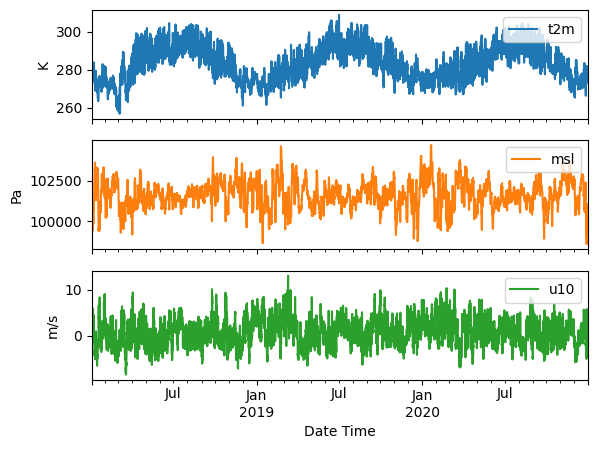

In [10]:
plot_cols = ['t2m', 'msl', 'u10']
time_steps = 3*365*24
plot_features = df[plot_cols][-time_steps:]
plot_features.index = df['Date Time'][-time_steps:]
axes = plot_features.plot(subplots=True)

labels = ['K', 'Pa', 'm/s']
for ax, label in zip(axes, labels):
    ax.set_ylabel(label)

legend_labels = ['Temperature', 'Mean Sea Level Pressure', 'E-W wind speed component']
for ax, legend_label in zip(axes, legend_labels):
    ax.plot(label=legend_label)
    ax.legend(loc="upper right")

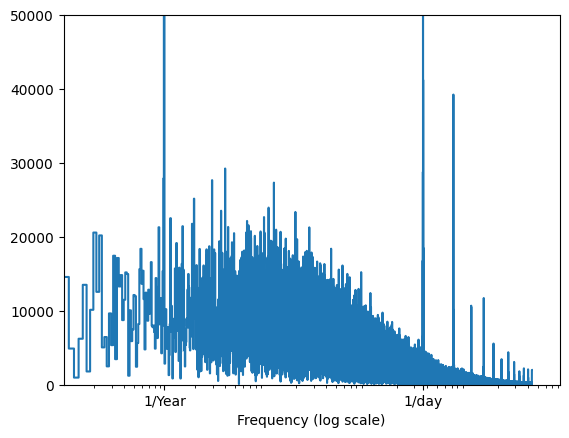

In [13]:
from tensorflow import signal
fft = signal.rfft(df['windspeed_10'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['windspeed_10'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 50000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

# Predkosc
## 1h

In [16]:
lookback = 24
future = 1
X_train, y_train, X_test, y_test, scaler_y = data_prep(df, 2012, 2019, 2020, 2020, lookback, future, y_featurename='windspeed_100')
y_index = 6

dense = Sequential([
            Dense(units=200, activation='relu', input_shape=(lookback, X_train.shape[2])),
            # Dropout(0.2),
            Dense(units=200, activation='relu'),
            # Dropout(0.2),
            Dense(units=200, activation='relu'),
            # Dropout(0.2),
            Dense(1),
            Reshape([1,24]),
            Dense(1),
            Reshape([1])
        ])

lstm = Sequential([
            LSTM(24, activation='relu', input_shape=(lookback, X_train.shape[2]), return_sequences=True),
            LSTM(24, activation='relu', return_sequences=True),
            LSTM(24, activation='relu'),
            Dense(1)
        ])

class mean_baseline():
    def predict(X):
        X = X[:,:,y_index].reshape((X.shape[0], X.shape[1], 1))
        Y = []
        for item in X:
            Y.append(np.mean(item))
        Y = np.array(Y).reshape(len(Y),1)
        return Y

class last_baseline():
    def predict(X):
        X = X[:,:,y_index].reshape((X.shape[0], X.shape[1], 1))
        Y = []
        for item in X:
            Y.append(item[-1])
        Y = np.array(Y).reshape(len(Y),1)
        return Y

mean = mean_baseline
last = last_baseline

In [17]:
compile_and_fit(dense, X_train, y_train)

Epoch 1/20
2191/2191 [==============================] - 9s 4ms/step - loss: 0.0039
Epoch 2/20
2191/2191 [==============================] - 7s 3ms/step - loss: 0.0017
Epoch 3/20
2191/2191 [==============================] - 7s 3ms/step - loss: 0.0014
Epoch 4/20
2191/2191 [==============================] - 7s 3ms/step - loss: 0.0012
Epoch 5/20
2191/2191 [==============================] - 7s 3ms/step - loss: 0.0010
Epoch 6/20
2191/2191 [==============================] - 7s 3ms/step - loss: 9.5288e-04
Epoch 7/20
2191/2191 [==============================] - 7s 3ms/step - loss: 9.2115e-04
Epoch 8/20
2191/2191 [==============================] - 7s 3ms/step - loss: 8.8725e-04
Epoch 9/20
2191/2191 [==============================] - 7s 3ms/step - loss: 8.7208e-04
Epoch 10/20
2191/2191 [==============================] - 7s 3ms/step - loss: 8.5624e-04
Epoch 11/20
2191/2191 [==============================] - 7s 3ms/step - loss: 8.4948e-04
Epoch 12/20
2191/2191 [==============================] - 8s 4

In [18]:
compile_and_fit(lstm, X_train, y_train)

Epoch 1/20
2191/2191 [==============================] - 49s 21ms/step - loss: 0.0026
Epoch 2/20
2191/2191 [==============================] - 46s 21ms/step - loss: 9.4145e-04
Epoch 3/20
2191/2191 [==============================] - 42s 19ms/step - loss: 8.6916e-04
Epoch 4/20
2191/2191 [==============================] - 42s 19ms/step - loss: 8.5316e-04
Epoch 5/20
2191/2191 [==============================] - 42s 19ms/step - loss: 8.3134e-04
Epoch 6/20
2191/2191 [==============================] - 44s 20ms/step - loss: 8.1769e-04
Epoch 7/20
2191/2191 [==============================] - 41s 19ms/step - loss: 8.0391e-04
Epoch 8/20
2191/2191 [==============================] - 38s 18ms/step - loss: 8.0347e-04
Epoch 9/20
2191/2191 [==============================] - 38s 18ms/step - loss: 7.9241e-04
Epoch 10/20
2191/2191 [==============================] - 37s 17ms/step - loss: 7.8444e-04
Epoch 11/20
2191/2191 [==============================] - 37s 17ms/step - loss: 7.8098e-04
Epoch 12/20
2191/2191 [

In [20]:
import os
from sklearn.metrics import mean_squared_error
def evaluate(model, X_test, y_test, scaler_y, display = True, save_to = '', y_label=''):
    # make predictions
    testPredictions = model.predict(X_test)

    # invert scalling
    testPredictions = scaler_y.inverse_transform(testPredictions)
    testYTrue = scaler_y.inverse_transform(y_test)

    # calculate RMSE
    testScore = sqrt(mean_squared_error(testYTrue, testPredictions))
    
    if display:
        print('Test Score: %.4f RMSE' % (testScore))
        length = 168
        # start = random.randrange(len(testYTrue)-length)
        start = 1000
        end = start+length
        plt.figure(figsize=[10,5])
        plt.xlabel('TimePoint in hours')
        plt.ylabel(y_label)
        plt.grid()
        plt.plot(range(length), testYTrue[start:end],'k.')
        plt.plot(range(length),testPredictions[start:end],'r')
        plt.legend(['Actual','Predicted'])
        os.makedirs(save_to.split('/')[0], exist_ok=True)
        plt.savefig(save_to)

    return testScore, testPredictions, testYTrue

  1/274 [..............................] - ETA: 9s

274/274 [==============================] - 1s 3ms/step
Test Score: 0.6056 RMSE


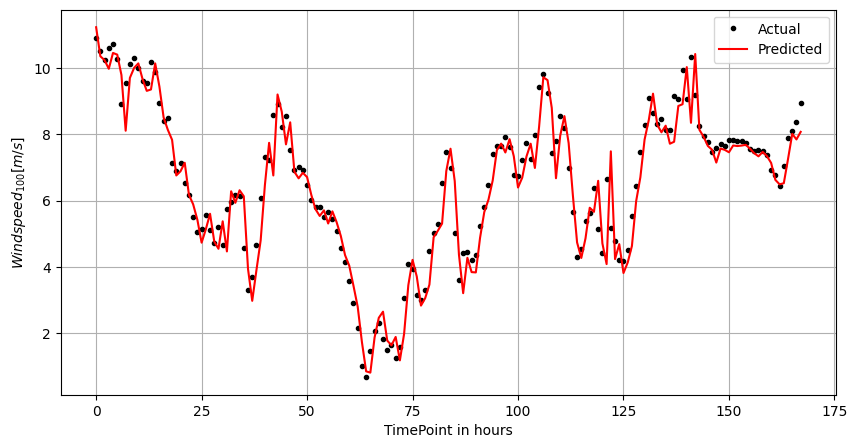

In [21]:
rmse_dense,_,_ = evaluate(dense, X_test, y_test, scaler_y, save_to='figures/speed_1h_dense_res.png', y_label='$Windspeed_{100}[m/s]$')

In [22]:
def cross_corr(model, X_test, y_test, scaler_y):
    # make predictions
    testPredictions = model.predict(X_test)

    # invert scalling
    testPredictions = scaler_y.inverse_transform(testPredictions)
    testYTrue = scaler_y.inverse_transform(y_test)
    testPredictions = testPredictions.reshape((testPredictions.shape[0]))
    testYTrue = testYTrue.reshape((testYTrue.shape[0]))

    plt.figure(figsize=[10,5])
    plt.xcorr(testYTrue, testPredictions, usevlines=False)
    plt.grid()
    plt.xticks(range(-10,11))
    plt.title("Cross correlation between predictions and actual values")

  1/274 [..............................] - ETA: 7s

274/274 [==============================] - 1s 2ms/step


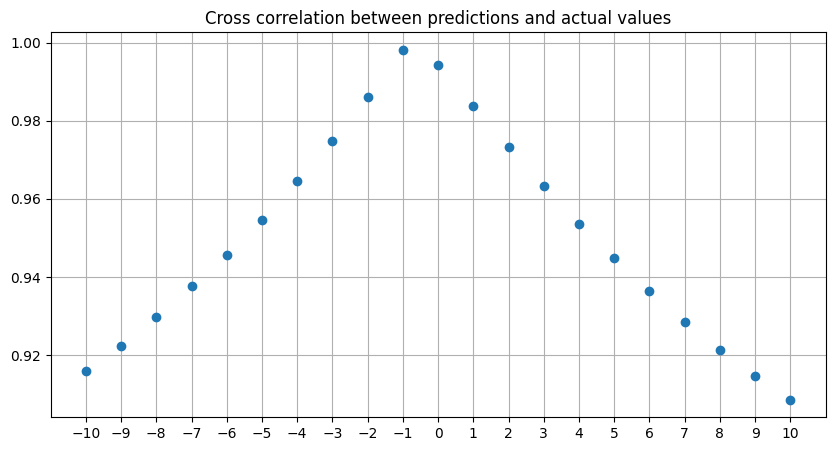

In [23]:
cross_corr(dense, X_test, y_test, scaler_y)

274/274 [==============================] - 2s 6ms/step
Test Score: 0.5889 RMSE


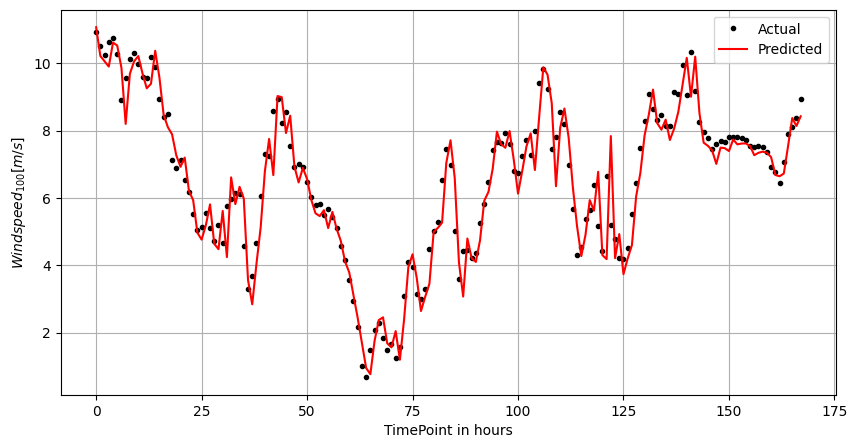

In [24]:
rmse_lstm,_,_ = evaluate(lstm, X_test, y_test, scaler_y, save_to='figures/speed_1h_lstm_res.png', y_label='$Windspeed_{100}[m/s]$')

  1/274 [..............................] - ETA: 7s

274/274 [==============================] - 1s 5ms/step


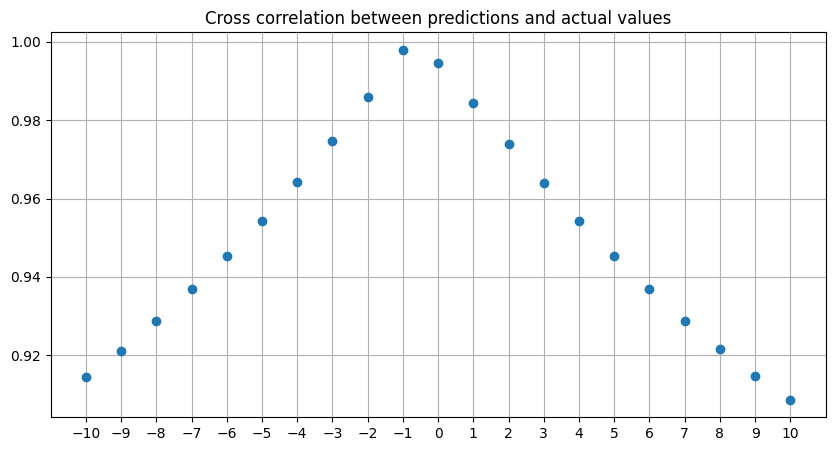

In [25]:
cross_corr(lstm, X_test, y_test, scaler_y)

Test Score: 0.6700 RMSE


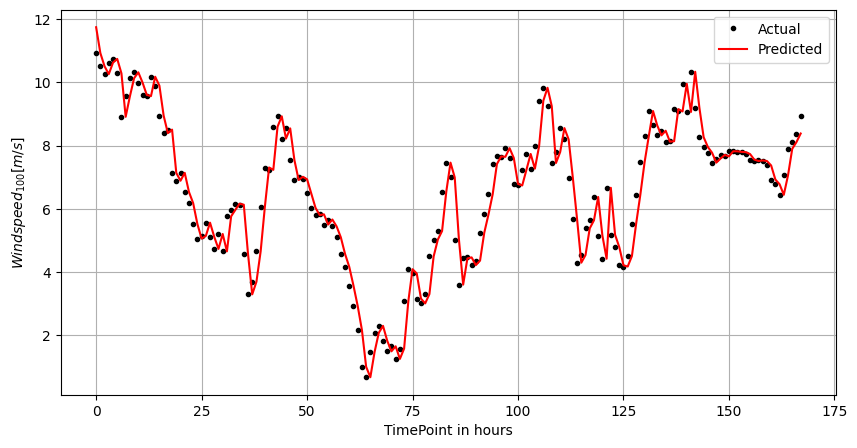

In [26]:
rmse_last,_,_ = evaluate(last, X_test, y_test, scaler_y, save_to='figures/speed_1h_last_res.png', y_label='$Windspeed_{100}[m/s]$')

Test Score: 1.9001 RMSE


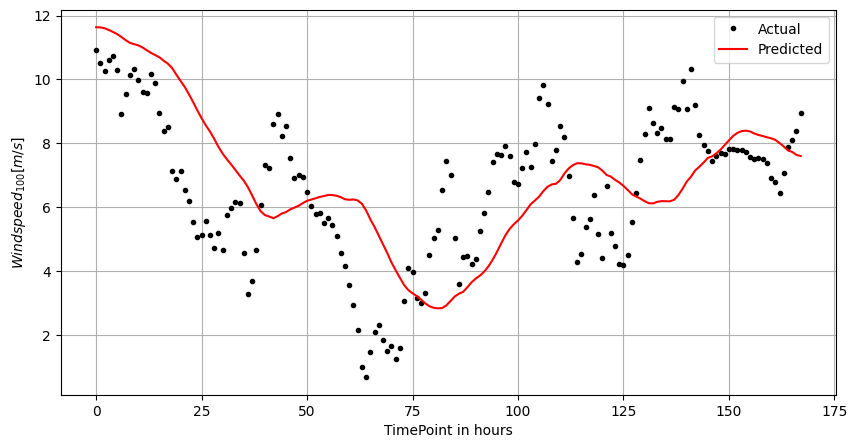

In [27]:
rmse_mean,_,_ = evaluate(mean, X_test, y_test, scaler_y, save_to='figures/speed_1h_mean_res.png', y_label='$Windspeed_{100}[m/s]$')

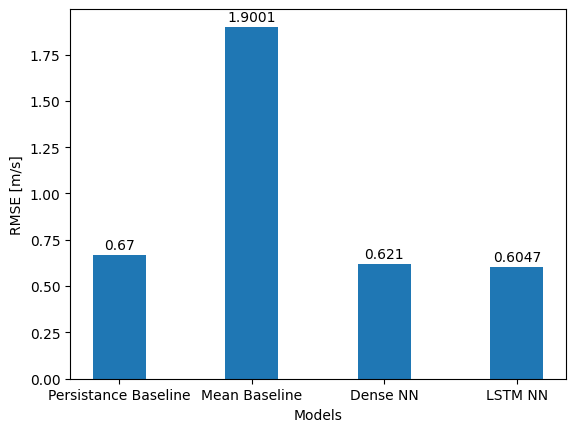

In [31]:
fig, ax = plt.subplots()

x = ['Persistance Baseline', 'Mean Baseline', 'Dense NN', 'LSTM NN']
y = [rmse_last, rmse_mean, rmse_dense, rmse_lstm]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('RMSE [m/s]')
# ax.set_ylim(0, 2.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.03, s=str(round(value,4)), ha='center')
    
# plt.tight_layout()

## 3h

In [28]:
lookback = 24
future = 3
X_train, y_train, X_test, y_test, scaler_y = data_prep(df, 2012, 2019, 2020, 2020, lookback, future, y_featurename='windspeed_100')
y_index = 6

dense = Sequential([
            Dense(units=200, activation='relu', input_shape=(lookback, X_train.shape[2])),
            # Dropout(0.2),
            Dense(units=200, activation='relu'),
            # Dropout(0.2),
            Dense(units=200, activation='relu'),
            # Dropout(0.2),
            Dense(1),
            Reshape([1,24]),
            Dense(1),
            Reshape([1])
        ])

lstm = Sequential([
            LSTM(24, activation='relu', input_shape=(lookback, X_train.shape[2]), return_sequences=True),
            LSTM(24, activation='relu', return_sequences=True),
            LSTM(24, activation='relu'),
            Dense(1)
        ])

class mean_baseline():
    def predict(X):
        X = X[:,:,y_index].reshape((X.shape[0], X.shape[1], 1))
        Y = []
        for item in X:
            Y.append(np.mean(item))
        Y = np.array(Y).reshape(len(Y),1)
        return Y

class last_baseline():
    def predict(X):
        X = X[:,:,y_index].reshape((X.shape[0], X.shape[1], 1))
        Y = []
        for item in X:
            Y.append(item[-future])
        Y = np.array(Y).reshape(len(Y),1)
        return Y

mean = mean_baseline
last = last_baseline

In [29]:
compile_and_fit(dense, X_train, y_train)

Epoch 1/20
2191/2191 [==============================] - 11s 5ms/step - loss: 0.0076
Epoch 2/20
2191/2191 [==============================] - 10s 4ms/step - loss: 0.0052
Epoch 3/20
2191/2191 [==============================] - 9s 4ms/step - loss: 0.0043
Epoch 4/20
2191/2191 [==============================] - 10s 5ms/step - loss: 0.0040
Epoch 5/20
2191/2191 [==============================] - 10s 5ms/step - loss: 0.0038
Epoch 6/20
2191/2191 [==============================] - 10s 4ms/step - loss: 0.0037
Epoch 7/20
2191/2191 [==============================] - 10s 5ms/step - loss: 0.0037
Epoch 8/20
2191/2191 [==============================] - 10s 5ms/step - loss: 0.0036
Epoch 9/20
2191/2191 [==============================] - 10s 5ms/step - loss: 0.0036
Epoch 10/20
2191/2191 [==============================] - 11s 5ms/step - loss: 0.0035
Epoch 11/20
2191/2191 [==============================] - 11s 5ms/step - loss: 0.0035
Epoch 12/20
2191/2191 [==============================] - 10s 5ms/step - los

In [30]:
compile_and_fit(lstm, X_train, y_train)

Epoch 1/20
2191/2191 [==============================] - 54s 23ms/step - loss: 0.0059
Epoch 2/20
2191/2191 [==============================] - 51s 23ms/step - loss: 0.0037
Epoch 3/20
2191/2191 [==============================] - 51s 23ms/step - loss: 0.0036
Epoch 4/20
2191/2191 [==============================] - 47s 22ms/step - loss: 0.0035
Epoch 5/20
2191/2191 [==============================] - 44s 20ms/step - loss: 0.0034
Epoch 6/20
2191/2191 [==============================] - 43s 20ms/step - loss: 0.0034
Epoch 7/20
2191/2191 [==============================] - 44s 20ms/step - loss: 0.0033
Epoch 8/20
2191/2191 [==============================] - 43s 20ms/step - loss: 0.0033
Epoch 9/20
2191/2191 [==============================] - 43s 20ms/step - loss: 0.0033
Epoch 10/20
2191/2191 [==============================] - 43s 20ms/step - loss: 0.0033
Epoch 11/20
2191/2191 [==============================] - 43s 20ms/step - loss: 0.0033
Epoch 12/20
2191/2191 [==============================] - 44s 20

274/274 [==============================] - 1s 3ms/step
Test Score: 1.2470 RMSE


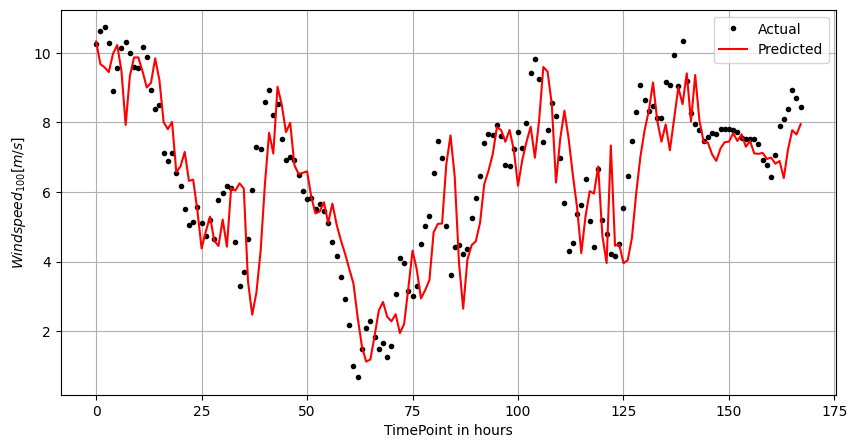

In [31]:
rmse_dense,_,_ = evaluate(dense, X_test, y_test, scaler_y, save_to='figures/speed_3h_dense_res.png', y_label='$Windspeed_{100}[m/s]$')

  1/274 [..............................] - ETA: 6s

274/274 [==============================] - 1s 4ms/step


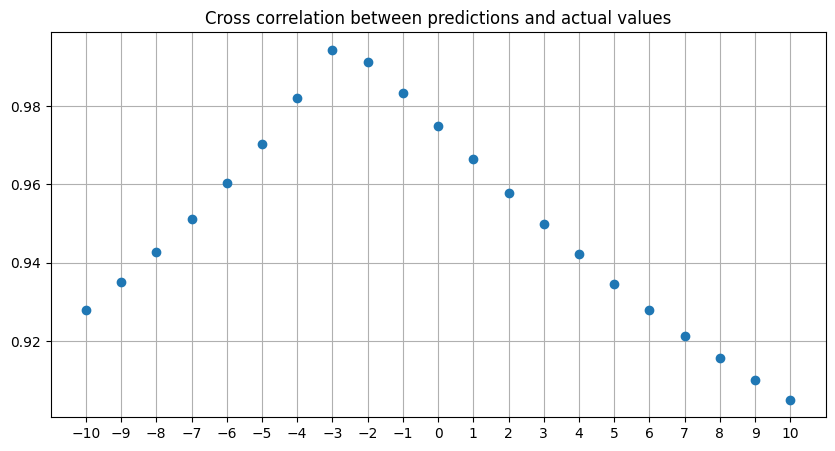

In [32]:
cross_corr(dense, X_test, y_test, scaler_y)

274/274 [==============================] - 3s 8ms/step
Test Score: 1.2263 RMSE


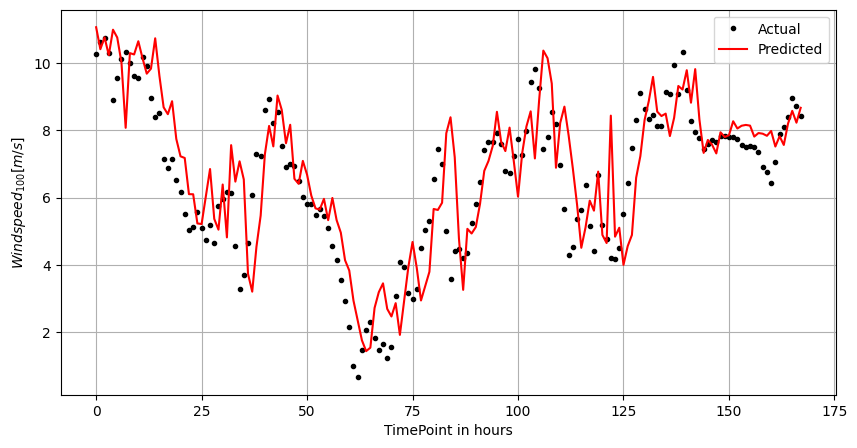

In [33]:
rmse_lstm,_,_ = evaluate(lstm, X_test, y_test, scaler_y, save_to='figures/speed_3h_lstm_res.png', y_label='$Windspeed_{100}[m/s]$')

  6/274 [..............................] - ETA: 2s

274/274 [==============================] - 2s 9ms/step


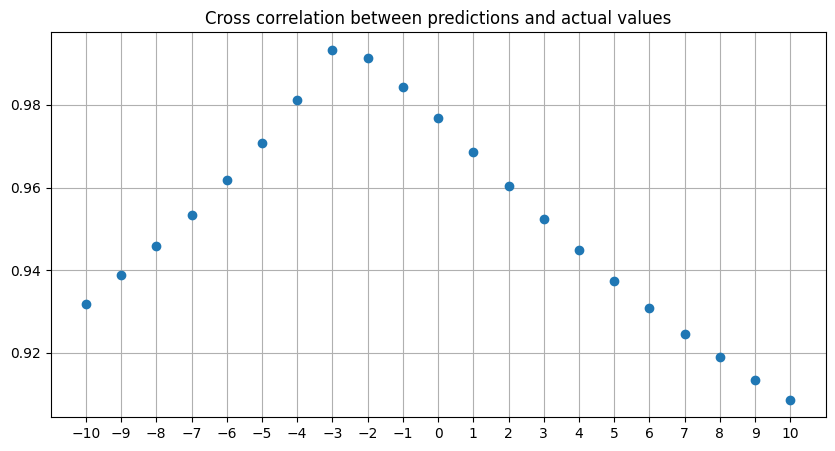

In [34]:
cross_corr(lstm, X_test, y_test, scaler_y)

Test Score: 1.7575 RMSE


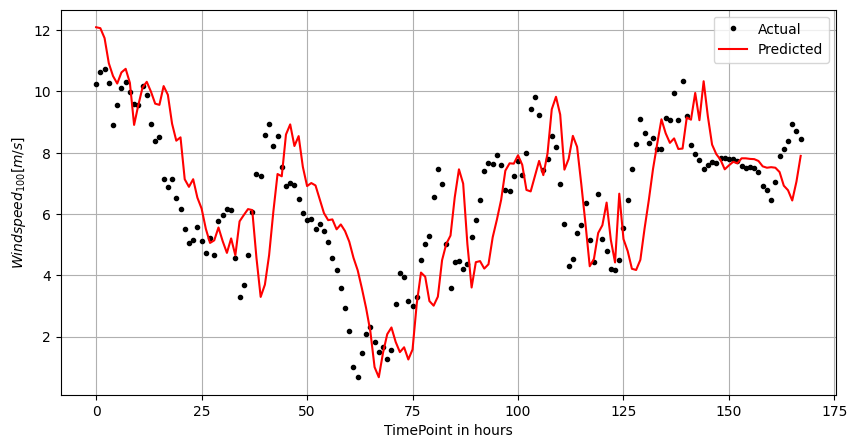

In [35]:
rmse_last,_,_ = evaluate(last, X_test, y_test, scaler_y, save_to='figures/speed_3h_last_res.png', y_label='$Windspeed_{100}[m/s]$')

Test Score: 2.0632 RMSE


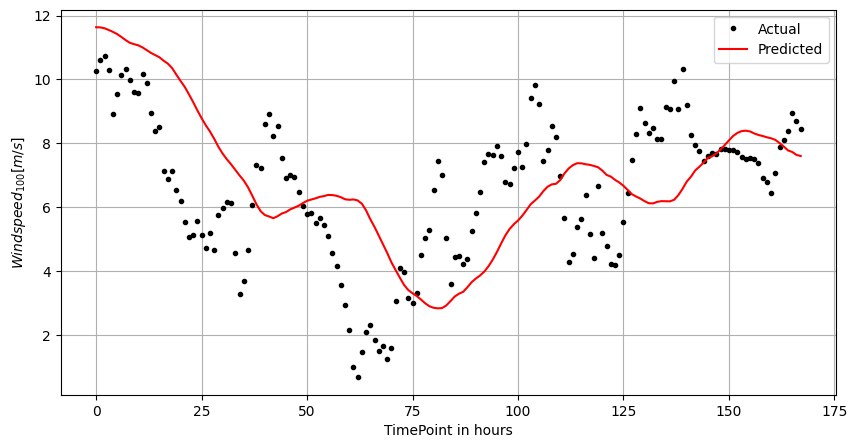

In [36]:
rmse_mean,_,_ = evaluate(mean, X_test, y_test, scaler_y, save_to='figures/speed_3h_mean_res.png', y_label='$Windspeed_{100}[m/s]$')

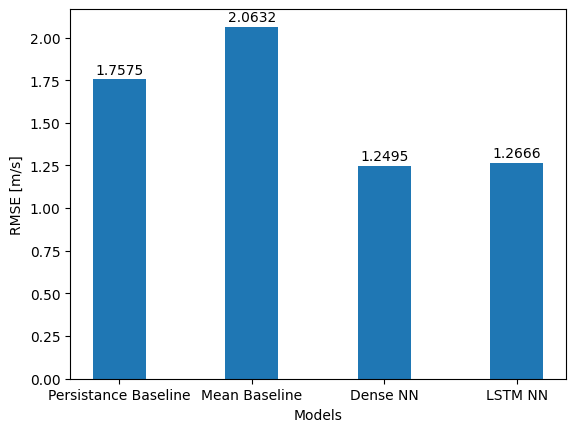

In [43]:
fig, ax = plt.subplots()

x = ['Persistance Baseline', 'Mean Baseline', 'Dense NN', 'LSTM NN']
y = [rmse_last, rmse_mean, rmse_dense, rmse_lstm]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('RMSE [m/s]')
# ax.set_ylim(0, 2.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.03, s=str(round(value,4)), ha='center')
    
# plt.tight_layout()

# 6h

In [95]:
def compile_and_fit(model, X_train, y_train):
    early_stopping = keras.callbacks.EarlyStopping(monitor='loss',
                                                   patience=2,
                                                   mode='min')

    model.compile(loss='mean_squared_error',
                  optimizer='adam')

    model.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[early_stopping])

In [37]:
lookback = 24
future = 6
X_train, y_train, X_test, y_test, scaler_y = data_prep(df, 1983, 1990, 1991, 1991, lookback, future, y_featurename='windspeed_100')
y_index = 6

dense = Sequential([
            Dense(units=200, activation='relu', input_shape=(lookback, X_train.shape[2])),
            # Dropout(0.2),
            Dense(units=200, activation='relu'),
            # Dropout(0.2),
            Dense(units=200, activation='relu'),
            # Dropout(0.2),
            Dense(1),
            Reshape([1,24]),
            Dense(1),
            Reshape([1])
        ])

lstm = Sequential([
            LSTM(24, activation='relu', input_shape=(lookback, X_train.shape[2]), return_sequences=True),
            LSTM(24, activation='relu', return_sequences=True),
            LSTM(24, activation='relu'),
            Dense(1)
        ])

class mean_baseline():
    def predict(X):
        X = X[:,:,y_index].reshape((X.shape[0], X.shape[1], 1))
        Y = []
        for item in X:
            Y.append(np.mean(item))
        Y = np.array(Y).reshape(len(Y),1)
        return Y

class last_baseline():
    def predict(X):
        X = X[:,:,y_index].reshape((X.shape[0], X.shape[1], 1))
        Y = []
        for item in X:
            Y.append(item[-future])
        Y = np.array(Y).reshape(len(Y),1)
        return Y

mean = mean_baseline
last = last_baseline

In [38]:
compile_and_fit(dense, X_train, y_train)

Epoch 1/20
2191/2191 [==============================] - 12s 5ms/step - loss: 0.0113
Epoch 2/20
2191/2191 [==============================] - 10s 5ms/step - loss: 0.0090
Epoch 3/20
2191/2191 [==============================] - 11s 5ms/step - loss: 0.0083
Epoch 4/20
2191/2191 [==============================] - 10s 5ms/step - loss: 0.0079
Epoch 5/20
2191/2191 [==============================] - 10s 5ms/step - loss: 0.0077
Epoch 6/20
2191/2191 [==============================] - 11s 5ms/step - loss: 0.0075
Epoch 7/20
2191/2191 [==============================] - 11s 5ms/step - loss: 0.0074
Epoch 8/20
2191/2191 [==============================] - 11s 5ms/step - loss: 0.0073
Epoch 9/20
2191/2191 [==============================] - 11s 5ms/step - loss: 0.0072
Epoch 10/20
2191/2191 [==============================] - 12s 5ms/step - loss: 0.0071
Epoch 11/20
2191/2191 [==============================] - 11s 5ms/step - loss: 0.0071
Epoch 12/20
2191/2191 [==============================] - 11s 5ms/step - lo

In [39]:
compile_and_fit(lstm, X_train, y_train)

Epoch 1/20
2191/2191 [==============================] - 37s 15ms/step - loss: 0.0098
Epoch 2/20
2191/2191 [==============================] - 34s 15ms/step - loss: 0.0074
Epoch 3/20
2191/2191 [==============================] - 36s 16ms/step - loss: 0.0071
Epoch 4/20
2191/2191 [==============================] - 36s 17ms/step - loss: 0.0069
Epoch 5/20
2191/2191 [==============================] - 36s 17ms/step - loss: 0.0069
Epoch 6/20
2191/2191 [==============================] - 36s 17ms/step - loss: 0.0068
Epoch 7/20
2191/2191 [==============================] - 38s 17ms/step - loss: 0.0067
Epoch 8/20
2191/2191 [==============================] - 40s 18ms/step - loss: 0.0066
Epoch 9/20
2191/2191 [==============================] - 40s 18ms/step - loss: 0.0065
Epoch 10/20
2191/2191 [==============================] - 36s 17ms/step - loss: 0.0065
Epoch 11/20
2191/2191 [==============================] - 47s 21ms/step - loss: 0.0065
Epoch 12/20
2191/2191 [==============================] - 45s 21

274/274 [==============================] - 2s 9ms/step


Text(0, 0.5, 'RMSE')

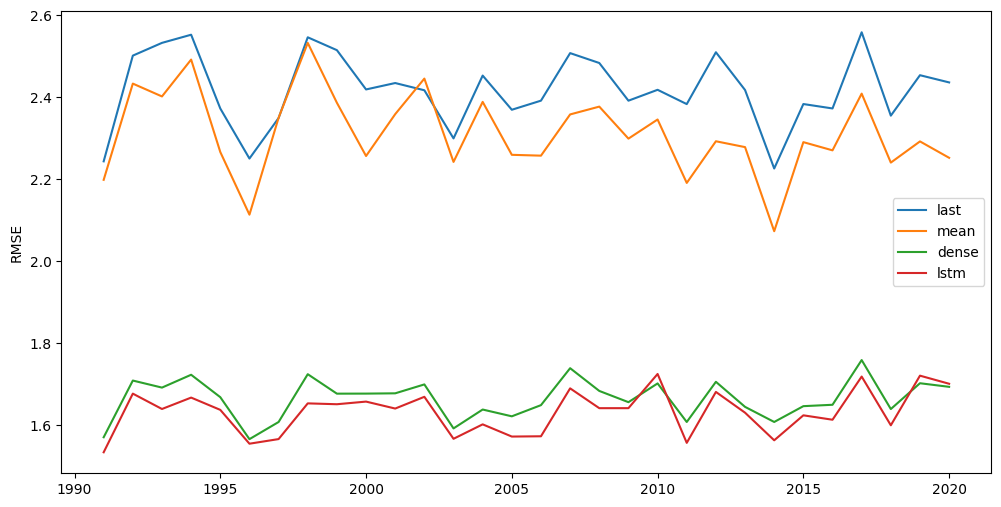

In [107]:
years = range(1991,2021)
# years = [str(x) for x in years]

Xs = []
ys = []

for year in years:
    _, _, X_test, y_test, scaler_y = data_prep(df, 1983, 1990, year, year, lookback, future, y_featurename='windspeed_100')
    Xs.append(X_test)
    ys.append(y_test)

models = {
    "last": last,
    "mean": mean,
    "dense":dense, 
    "lstm":lstm
}

scores = {}
for key, model in models.items():
    rmses = []
    for i in range(len(years)):
        # rmse = evaluate(model, Xs[i], ys[i], display=False)
        rmse,_,_ = evaluate(model, Xs[i], ys[i], scaler_y, display=False)
        rmses.append(rmse)
    scores[key] = rmses

plt.figure(figsize=(12,6))
for key in scores.keys():
    plt.plot(years, scores[key])
plt.legend(scores.keys())
plt.ylabel("RMSE")

Text(0, 0.5, 'RMSE')

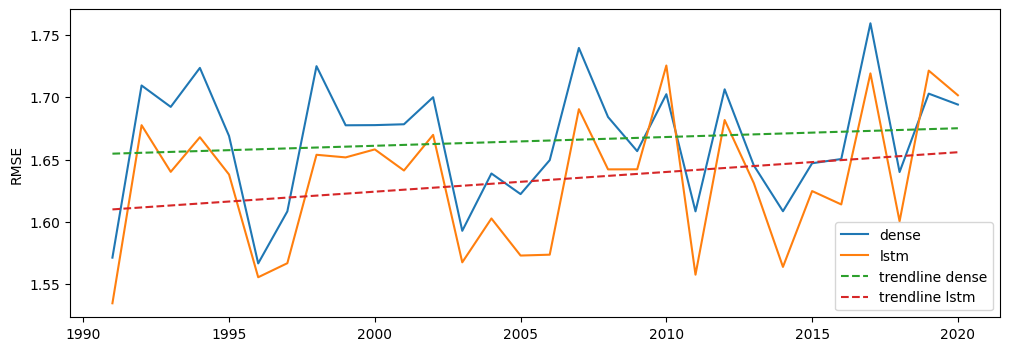

In [115]:
plt.figure(figsize=(12,4))
for key in ['dense','lstm']:
    plt.plot(years, scores[key])
z1 = np.polyfit(years, scores['dense'], 1)
p1 = np.poly1d(z1)
plt.plot(years, p1(years), linestyle="--")
z2 = np.polyfit(years, scores['lstm'], 1)
p2 = np.poly1d(z2)
plt.plot(years, p2(years), linestyle="--")
plt.legend(['dense','lstm', 'trendline dense', 'trendline lstm'])
plt.ylabel("RMSE")

273/273 [==============================] - 1s 3ms/step
Test Score: 1.5691 RMSE


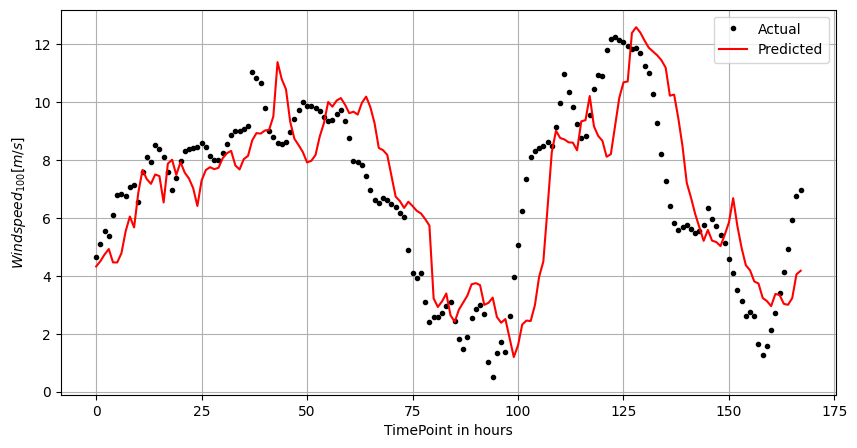

In [40]:
rmse_dense,_,_ = evaluate(dense, X_test, y_test, scaler_y, save_to='figures/speed_6h_dense_res.png', y_label='$Windspeed_{100}[m/s]$')

  1/273 [..............................] - ETA: 7s

273/273 [==============================] - 1s 3ms/step


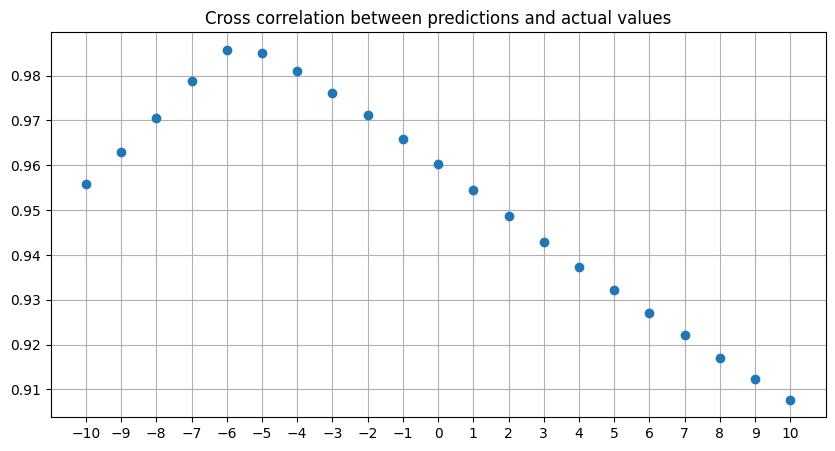

In [41]:
cross_corr(dense, X_test, y_test, scaler_y)

273/273 [==============================] - 3s 8ms/step
Test Score: 1.5159 RMSE


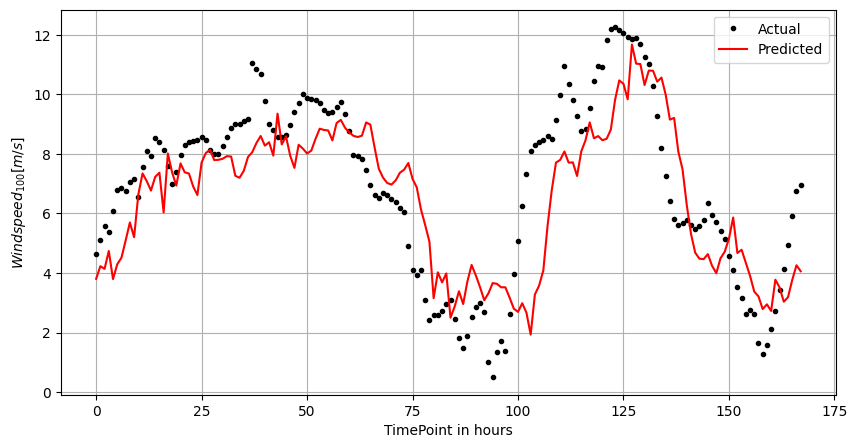

In [42]:
rmse_lstm,_,_ = evaluate(lstm, X_test, y_test, scaler_y, save_to='figures/speed_6h_lstm_res.png', y_label='$Windspeed_{100}[m/s]$')

  1/273 [..............................] - ETA: 7s

273/273 [==============================] - 2s 8ms/step


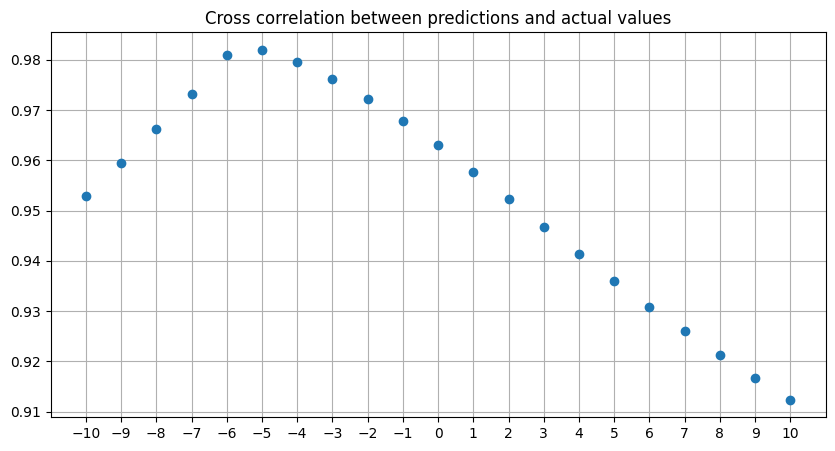

In [43]:
cross_corr(lstm, X_test, y_test, scaler_y)

Test Score: 2.2436 RMSE


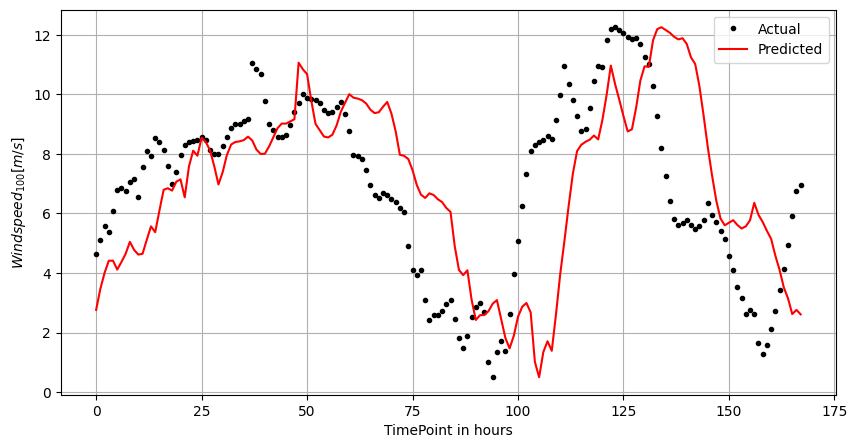

In [44]:
rmse_last,_,_ = evaluate(last, X_test, y_test, scaler_y, save_to='figures/speed_6h_last_res.png', y_label='$Windspeed_{100}[m/s]$')

Test Score: 2.1986 RMSE


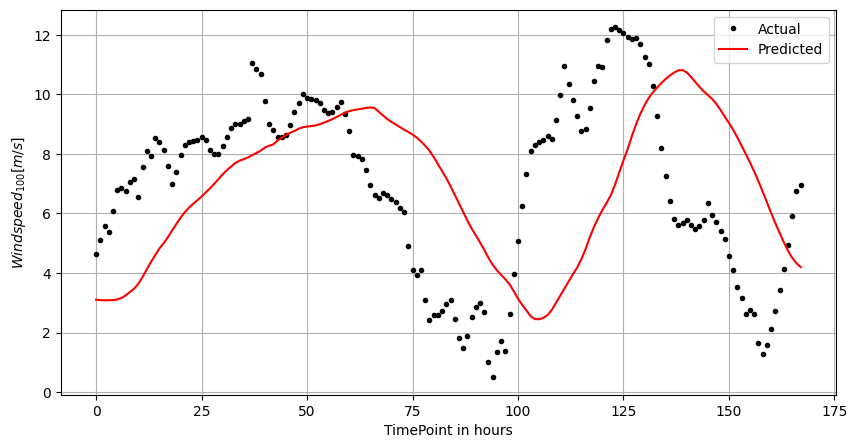

In [45]:
rmse_mean,_,_ = evaluate(mean, X_test, y_test, scaler_y, save_to='figures/speed_6h_mean_res.png', y_label='$Windspeed_{100}[m/s]$')

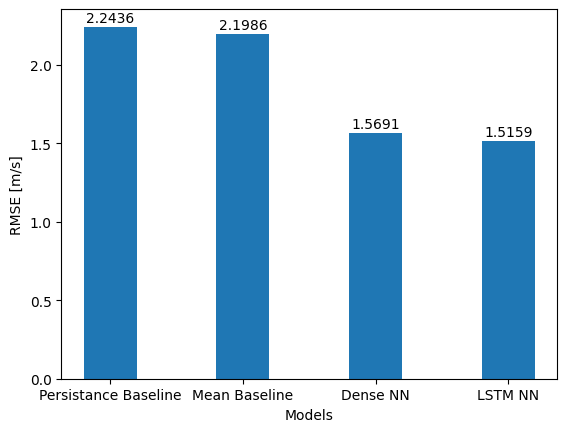

In [46]:
fig, ax = plt.subplots()

x = ['Persistance Baseline', 'Mean Baseline', 'Dense NN', 'LSTM NN']
y = [rmse_last, rmse_mean, rmse_dense, rmse_lstm]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('RMSE [m/s]')
# ax.set_ylim(0, 2.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.03, s=str(round(value,4)), ha='center')
    
# plt.tight_layout()

## Gradienty

## Przestrzenne

In [69]:
def create_datasets(filename):
    f = netCDF4.Dataset(filename)
    var_names = ['t2m', 'd2m', 'msl', 'tp', 'u10', 'v10', 'u100', 'v100', 'ssrd']
    latitudes = f.variables['latitude'][:]
    longitudes = f.variables['longitude'][:]
    times = netCDF4.num2date(f.variables['time'][:], f.variables['time'].units, only_use_cftime_datetimes=False, only_use_python_datetimes=True)
    times = [t.isoformat() for t in times]
    dataframes = []
    for i in range(len(latitudes)):
        row = []
        for j in range(len(longitudes)):
            variables = {key: f.variables[key][:,i,j] for key in var_names}
            df = pd.DataFrame({**{
                'Date Time': times,
                **variables
            }})
            df['Date Time'] = pd.to_datetime(df.pop('Date Time'), infer_datetime_format=True)
            df['tp'] = df['tp'].fillna(0)
            ssrd_new = df['ssrd']
            ssrd_new = ssrd_new.where(ssrd_new>10, 0) / 3600 / 1000 #unit from [J/m^2] to [kW/m^2]
            df['ssrd'] = ssrd_new
            df['windspeed_10'] = (df['u10']**2 + df['v10']**2)**(1/2)
            df['windspeed_100'] = (df['u100']**2 + df['v100']**2)**(1/2)
            df.drop(labels=['u10', 'v10', 'u100', 'v100'], axis=1, inplace = True)
            row.append(df)
        dataframes.append(row)
    f.close()
    return dataframes

datasets = create_datasets('data/ERA5_area/data_area_1994.nc')
for year in range(1995, 2003):
    datasets_new = create_datasets('data/ERA5_area/data_area_{}.nc'.format(year))
    for i, row in enumerate(datasets):
        for j, col in enumerate(row):
            # datasets[i][j] = datasets[i][j].append(datasets_new[i][j])
            datasets[i][j] = pd.concat([datasets[i][j], datasets_new[i][j]], ignore_index=True)

In [73]:
temperatures = np.zeros(shape=(len(datasets[0][0]), len(datasets), len(datasets[0])))
pressures = np.zeros(shape=(len(datasets[0][0]), len(datasets), len(datasets[0])))
for i, row in enumerate(datasets):
    for j, element in enumerate(row):
        for index in range(len(datasets[0][0])):
            temperatures[index,i,j] = element['t2m'][index]
            pressures[index,i,j] = element['msl'][index]

temp_grad = []
for i in range(temperatures.shape[0]):
    gradx = np.gradient(temperatures[i])[0][4,4]
    grady = np.gradient(temperatures[i])[1][4,4]
    grad = np.sqrt(gradx**2+grady**2)
    temp_grad.append(grad)

pres_grad = []
for i in range(pressures.shape[0]):
    gradx = np.gradient(pressures[i])[0][4,4]
    grady = np.gradient(pressures[i])[1][4,4]
    grad = np.sqrt(gradx**2+grady**2)
    pres_grad.append(grad)

df = datasets[4][4]

df['temp_grad_space'] = temp_grad
df['press_grad_space'] = pres_grad

In [75]:
df

,t2m,d2m,msl,tp,ssrd,Date Time,windspeed_10,windspeed_100,temp_grad_space,press_grad_space
0,276.591677,273.597511,100506.631227,1.948620e-06,0.0,1994-01-01 00:00:00,2.114012,5.362126,0.966729,44.412578
1,276.239812,273.369413,100396.295800,4.871549e-07,0.0,1994-01-01 01:00:00,2.405844,5.321953,1.020768,65.151955
2,276.160179,273.007498,100208.275227,8.673617e-19,0.0,1994-01-01 02:00:00,2.965654,6.456440,0.784604,53.914795
3,276.464820,273.139795,100168.467620,8.673617e-19,0.0,1994-01-01 03:00:00,2.014695,4.494271,0.738976,26.661550
4,276.756498,273.067564,100306.869420,1.428988e-05,0.0,1994-01-01 04:00:00,2.988498,6.387397,0.693707,27.325593
...,...,...,...,...,...,...,...,...,...,...
78883,262.033295,257.549995,102196.336787,0.000000e+00,0.0,2002-12-31 19:00:00,3.407875,6.792493,0.628586,24.536909
78884,260.770309,256.287860,102251.588594,0.000000e+00,0.0,2002-12-31 20:00:00,3.086133,6.535490,0.998786,22.012362
78885,260.166196,255.696455,102277.340173,0.000000e+00,0.0,2002-12-31 21:00:00,2.725004,6.217745,1.478322,18.809599
78886,259.819096,255.709021,102266.827661,0.000000e+00,0.0,2002-12-31 22:00:00,2.124308,4.896523,2.053393,27.035475


In [79]:
lookback = 24
future = 6
X_train, y_train, X_test, y_test, scaler_y = data_prep(df, 1994, 2001, 2002, 2002, lookback, future, y_featurename='windspeed_100')
y_index = 6

dense = Sequential([
            Dense(units=200, activation='relu', input_shape=(lookback, X_train.shape[2])),
            # Dropout(0.2),
            Dense(units=200, activation='relu'),
            # Dropout(0.2),
            Dense(units=200, activation='relu'),
            # Dropout(0.2),
            Dense(1),
            Reshape([1,24]),
            Dense(1),
            Reshape([1])
        ])

In [80]:
def compile_and_fit(model, X_train, y_train):
    early_stopping = keras.callbacks.EarlyStopping(monitor='loss',
                                                   patience=2,
                                                   mode='min')

    model.compile(loss='mean_squared_error',
                  optimizer='adam')

    model.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[early_stopping])

In [81]:
compile_and_fit(dense, X_train, y_train)

Epoch 1/20
2191/2191 [==============================] - 26s 12ms/step - loss: 0.0092
Epoch 2/20
2191/2191 [==============================] - 26s 12ms/step - loss: 0.0080
Epoch 3/20
2191/2191 [==============================] - 27s 12ms/step - loss: 0.0075
Epoch 4/20
2191/2191 [==============================] - 27s 12ms/step - loss: 0.0071
Epoch 5/20
2191/2191 [==============================] - 26s 12ms/step - loss: 0.0069
Epoch 6/20
2191/2191 [==============================] - 26s 12ms/step - loss: 0.0067
Epoch 7/20
2191/2191 [==============================] - 26s 12ms/step - loss: 0.0067
Epoch 8/20
2191/2191 [==============================] - 29s 13ms/step - loss: 0.0066
Epoch 9/20
2191/2191 [==============================] - 29s 13ms/step - loss: 0.0065
Epoch 10/20
2191/2191 [==============================] - 28s 13ms/step - loss: 0.0065
Epoch 11/20
2191/2191 [==============================] - 27s 12ms/step - loss: 0.0064
Epoch 12/20
2191/2191 [==============================] - 27s 13

273/273 [==============================] - 2s 5ms/step
Test Score: 1.6848 RMSE


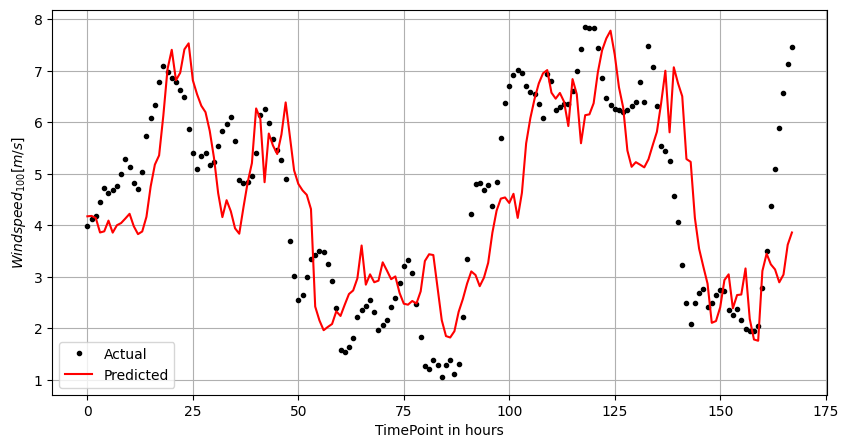

In [82]:
rmse_dense_grads_space,_,_ = evaluate(dense, X_test, y_test, scaler_y, save_to='figures/speed_6h_dense_with_space_grads_res.png', y_label='$Windspeed_{100}[m/s]$')

# Czasowe

In [86]:
temperature = df['t2m']
pressure = df['msl']

temp_grad_t = np.gradient(temperature)
press_grad_t = np.gradient(pressure)

df['temp_grad_t'] = temp_grad_t
df['press_grad_t'] = press_grad_t

df.drop(['temp_grad_space', 'press_grad_space'], axis=1, inplace = True)
df

,t2m,d2m,msl,tp,ssrd,Date Time,windspeed_10,windspeed_100,temp_grad_t,press_grad_t
0,276.591677,273.597511,100506.631227,1.948620e-06,0.0,1994-01-01 00:00:00,2.114012,5.362126,-0.351865,-110.335426
1,276.239812,273.369413,100396.295800,4.871549e-07,0.0,1994-01-01 01:00:00,2.405844,5.321953,-0.215749,-149.178000
2,276.160179,273.007498,100208.275227,8.673617e-19,0.0,1994-01-01 02:00:00,2.965654,6.456440,0.112504,-113.914090
3,276.464820,273.139795,100168.467620,8.673617e-19,0.0,1994-01-01 03:00:00,2.014695,4.494271,0.298159,49.297097
4,276.756498,273.067564,100306.869420,1.428988e-05,0.0,1994-01-01 04:00:00,2.988498,6.387397,0.258806,72.015579
...,...,...,...,...,...,...,...,...,...,...
78883,262.033295,257.549995,102196.336787,0.000000e+00,0.0,2002-12-31 19:00:00,3.407875,6.792493,-0.900871,43.965117
78884,260.770309,256.287860,102251.588594,0.000000e+00,0.0,2002-12-31 20:00:00,3.086133,6.535490,-0.933550,40.501693
78885,260.166196,255.696455,102277.340173,0.000000e+00,0.0,2002-12-31 21:00:00,2.725004,6.217745,-0.475607,7.619534
78886,259.819096,255.709021,102266.827661,0.000000e+00,0.0,2002-12-31 22:00:00,2.124308,4.896523,-0.258338,-7.497295


In [87]:
lookback = 24
future = 6
X_train, y_train, X_test, y_test, scaler_y = data_prep(df, 1994, 2001, 2002, 2002, lookback, future, y_featurename='windspeed_100')
y_index = 6

dense = Sequential([
            Dense(units=200, activation='relu', input_shape=(lookback, X_train.shape[2])),
            # Dropout(0.2),
            Dense(units=200, activation='relu'),
            # Dropout(0.2),
            Dense(units=200, activation='relu'),
            # Dropout(0.2),
            Dense(1),
            Reshape([1,24]),
            Dense(1),
            Reshape([1])
        ])

In [88]:
compile_and_fit(dense, X_train, y_train)

Epoch 1/20
2191/2191 [==============================] - 26s 12ms/step - loss: 0.0105
Epoch 2/20
2191/2191 [==============================] - 25s 12ms/step - loss: 0.0076
Epoch 3/20
2191/2191 [==============================] - 26s 12ms/step - loss: 0.0071
Epoch 4/20
2191/2191 [==============================] - 25s 12ms/step - loss: 0.0069
Epoch 5/20
2191/2191 [==============================] - 26s 12ms/step - loss: 0.0068
Epoch 6/20
2191/2191 [==============================] - 26s 12ms/step - loss: 0.0067
Epoch 7/20
2191/2191 [==============================] - 27s 12ms/step - loss: 0.0066
Epoch 8/20
2191/2191 [==============================] - 27s 12ms/step - loss: 0.0065
Epoch 9/20
2191/2191 [==============================] - 27s 12ms/step - loss: 0.0065
Epoch 10/20
2191/2191 [==============================] - 27s 12ms/step - loss: 0.0064
Epoch 11/20
2191/2191 [==============================] - 26s 12ms/step - loss: 0.0064
Epoch 12/20
2191/2191 [==============================] - 26s 12

273/273 [==============================] - 1s 5ms/step
Test Score: 1.6406 RMSE


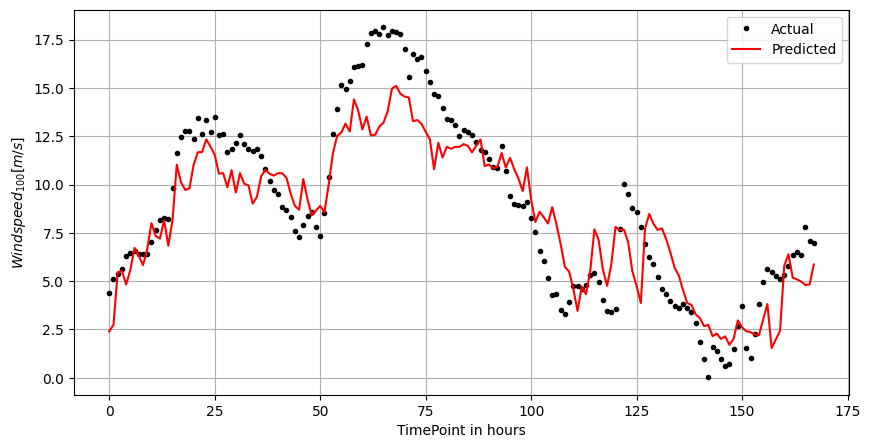

In [89]:
rmse_dense_grads_time,_,_ = evaluate(dense, X_test, y_test, scaler_y, save_to='figures/speed_6h_dense_with_time_grads_res.png', y_label='$Windspeed_{100}[m/s]$')

# Wszystkie

In [90]:
df['temp_grad_space'] = temp_grad
df['press_grad_space'] = pres_grad

In [92]:
lookback = 24
future = 6
X_train, y_train, X_test, y_test, scaler_y = data_prep(df, 1994, 2001, 2002, 2002, lookback, future, y_featurename='windspeed_100')
y_index = 6

dense = Sequential([
            Dense(units=200, activation='relu', input_shape=(lookback, X_train.shape[2])),
            # Dropout(0.2),
            Dense(units=200, activation='relu'),
            # Dropout(0.2),
            Dense(units=200, activation='relu'),
            # Dropout(0.2),
            Dense(1),
            Reshape([1,24]),
            Dense(1),
            Reshape([1])
        ])

In [93]:
compile_and_fit(dense, X_train, y_train)

Epoch 1/20
2191/2191 [==============================] - 24s 11ms/step - loss: 0.0088
Epoch 2/20
2191/2191 [==============================] - 24s 11ms/step - loss: 0.0074
Epoch 3/20
2191/2191 [==============================] - 24s 11ms/step - loss: 0.0069
Epoch 4/20
2191/2191 [==============================] - 25s 11ms/step - loss: 0.0067
Epoch 5/20
2191/2191 [==============================] - 25s 11ms/step - loss: 0.0065
Epoch 6/20
2191/2191 [==============================] - 24s 11ms/step - loss: 0.0064
Epoch 7/20
2191/2191 [==============================] - 25s 11ms/step - loss: 0.0064
Epoch 8/20
2191/2191 [==============================] - 24s 11ms/step - loss: 0.0063
Epoch 9/20
2191/2191 [==============================] - 26s 12ms/step - loss: 0.0062
Epoch 10/20
2191/2191 [==============================] - 25s 12ms/step - loss: 0.0062
Epoch 11/20
2191/2191 [==============================] - 25s 11ms/step - loss: 0.0061
Epoch 12/20
2191/2191 [==============================] - 25s 11

273/273 [==============================] - 1s 4ms/step
Test Score: 1.6380 RMSE


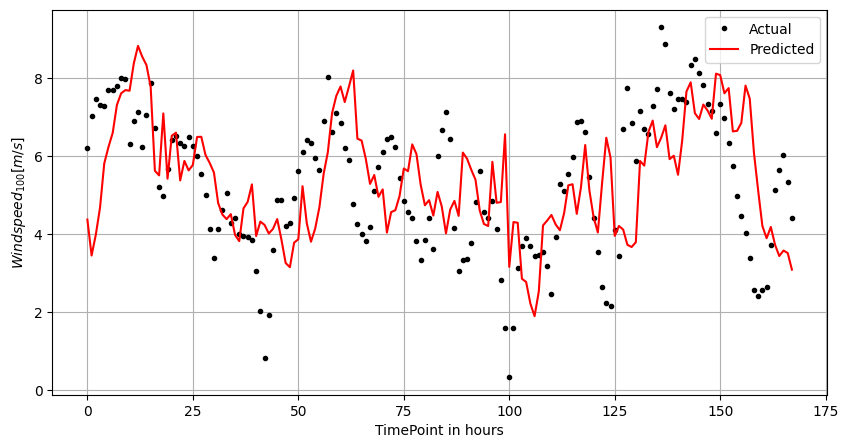

In [94]:
rmse_dense_grads_all,_,_ = evaluate(dense, X_test, y_test, scaler_y, save_to='figures/speed_6h_dense_with_all_grads_res.png', y_label='$Windspeed_{100}[m/s]$')